## Binary tree

### Toy corpus

In [8]:
import math

# 1. Vocabulary
corpus = [
    "the cat sat down",
    "the cat ate food",
    "the dog sat down",
    "the dog ate food",
    "a cat chased a mouse",
    "the dog chased the cat",
    "a dog barked loudly",
]
words = sorted(set(" ".join(corpus).split()))

print("Vocabulary:", words)
print("Vocabulary Size:", len(words))


Vocabulary: ['a', 'ate', 'barked', 'cat', 'chased', 'dog', 'down', 'food', 'loudly', 'mouse', 'sat', 'the']
Vocabulary Size: 12


### Helper functions

#### Analyzing the tree depth  

In [9]:
def analyze_tree(tree, prefix="", paths=None, depths=None, freqs=None):
    """
    Analyze tree paths, depths and frequencies recursively
    If freqs is None, uses weight=1 for each word
    """
    # Initialize dictionaries
    paths = {} if paths is None else paths
    depths = {} if depths is None else depths
    freqs = {} if freqs is None else freqs
    
    # If leaf node, record path, depth and frequency
    if not tree.get('left') and not tree.get('right'):
        word = tree['name']
        freq = tree.get('freq', 1)  # Default frequency = 1 if not specified
        paths[word] = prefix
        depths[word] = len(prefix)
        freqs[word] = freq
        return paths, depths, freqs
    
    # Recurse on children
    if tree.get('left'):
        analyze_tree(tree['left'], prefix + "0", paths, depths, freqs)
    if tree.get('right'):
        analyze_tree(tree['right'], prefix + "1", paths, depths, freqs)
    
    return paths, depths, freqs

def print_tree_analysis(tree, tree_type):
    """Print analysis of tree with optional frequency weighting"""
    paths, depths, freqs = analyze_tree(tree)
    total_freq = sum(freqs.values())
    
    print(f"\n{tree_type} Analysis:")
    print("-" * 40)
    
    # Print paths and depths
    print("Paths to words:")
    for word, path in sorted(paths.items()):
        freq = freqs[word]
        percentage = (freq / total_freq) * 100 if total_freq > 0 else 0
        print(f"  {word:10} : {path:8} (depth: {depths[word]:2d}, freq: {freq:2d}, {percentage:5.1f}%)")
    
    # Calculate statistics
    min_depth = min(depths.values())
    max_depth = max(depths.values())
    avg_depth = sum(depths.values()) / len(depths)
    weighted_avg = sum(depths[w] * freqs[w] for w in paths) / total_freq if total_freq > 0 else avg_depth
    
    print("\nDepth statistics:")
    print(f"  Min depth         : {min_depth}")
    print(f"  Max depth         : {max_depth}")
    print(f"  Average depth     : {avg_depth:.2f}")
    print(f"  Weighted average  : {weighted_avg:.2f}")
    print(f"  Total frequency   : {total_freq}")

#### Visualization of tree

In [10]:
from collections import deque

def visualize_tree_svg(tree, width=800, y_gap=100, leaf_radius=20, internal_radius=15, 
                      highlight_path=None, title=None):
    """
    tree: nested dict, each node has 'name', optional 'left'/'right'
    highlight_path: list of node names to highlight edges or leaves (optional)
    title: optional title to display above the tree
    """
    if highlight_path is None:
        highlight_path = []

    # Adjust initial y offset if title is present
    title_offset = 30 if title else 0
    base_y = 50 + title_offset

    # Step 1: Assign coordinates (root centered)
    # BFS to get nodes by depth
    by_depth = {}
    q = deque([(tree, 0)])
    max_depth = 0
    while q:
        node, depth = q.popleft()
        by_depth.setdefault(depth, []).append(node)
        max_depth = max(max_depth, depth)
        if node.get('left'):
            q.append((node['left'], depth+1))
        if node.get('right'):
            q.append((node['right'], depth+1))

    # Assign x,y per depth, equally spaced
    for depth, nodes in by_depth.items():
        count = len(nodes)
        for idx, node in enumerate(nodes):
            x = (idx + 0.5) * (width / max(1, count))
            y = base_y + depth * y_gap
            node['x'], node['y'] = x, y

    # Step 2: Collect edges
    edges = []
    def collect_edges(n):
        if n is None: return
        if n.get('left'):
            edges.append((n, n['left']))
            collect_edges(n['left'])
        if n.get('right'):
            edges.append((n, n['right']))
            collect_edges(n['right'])
    collect_edges(tree)

    # Step 3: Generate SVG
    total_height = base_y + (max_depth+1)*y_gap
    svg = [f'<svg width="{width}" height="{total_height}" xmlns="http://www.w3.org/2000/svg">']
    
    # Add title if provided
    if title:
        svg.append(f'<text x="{width/2}" y="25" text-anchor="middle" '
                  f'font-size="16" font-weight="bold">{title}</text>')

    # Draw edges
    for parent, child in edges:
        x1, y1 = parent['x'], parent['y']
        x2, y2 = child['x'], child['y']
        stroke = "red" if parent['name'] in highlight_path and child['name'] in highlight_path else "black"
        stroke_width = 2 if stroke=="red" else 1
        svg.append(f'<line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" '
                  f'stroke="{stroke}" stroke-width="{stroke_width}"/>')

    # Draw nodes recursively
    seen = set()
    q = deque([tree])
    while q:
        node = q.popleft()
        if id(node) in seen:
            continue
        seen.add(id(node))
        is_leaf = not node.get('left') and not node.get('right')
        r = leaf_radius if is_leaf else internal_radius
        fill = "lightgray" if is_leaf else "white"
        stroke = "red" if is_leaf and node['name'] in highlight_path else "black"
        stroke_width = 2 if stroke=="red" else 1
        svg.append(f'<circle cx="{node["x"]}" cy="{node["y"]}" r="{r}" '
                  f'fill="{fill}" stroke="{stroke}" stroke-width="{stroke_width}"/>')
        # label
        if is_leaf:
            svg.append(f'<text x="{node["x"]-len(node["name"])*3}" '
                      f'y="{node["y"]+r+15}" font-size="12">{node["name"]}</text>')
        else:
            svg.append(f'<text x="{node["x"]+r+5}" '
                      f'y="{node["y"]+5}" font-size="12">{node["name"]}</text>')
        if node.get('left'): q.append(node['left'])
        if node.get('right'): q.append(node['right'])

    svg.append('</svg>')
    return "\n".join(svg)

from IPython.display import SVG

### Perfect Binary Tree


Perfect Tree Analysis:
----------------------------------------
Paths to words:
  a          : 0000     (depth:  4, freq:  1,   8.3%)
  ate        : 0001     (depth:  4, freq:  1,   8.3%)
  barked     : 0010     (depth:  4, freq:  1,   8.3%)
  cat        : 0011     (depth:  4, freq:  1,   8.3%)
  chased     : 0100     (depth:  4, freq:  1,   8.3%)
  dog        : 0101     (depth:  4, freq:  1,   8.3%)
  down       : 0110     (depth:  4, freq:  1,   8.3%)
  food       : 0111     (depth:  4, freq:  1,   8.3%)
  loudly     : 1000     (depth:  4, freq:  1,   8.3%)
  mouse      : 1001     (depth:  4, freq:  1,   8.3%)
  sat        : 1010     (depth:  4, freq:  1,   8.3%)
  the        : 1011     (depth:  4, freq:  1,   8.3%)

Depth statistics:
  Min depth         : 4
  Max depth         : 4
  Average depth     : 4.00
  Weighted average  : 4.00
  Total frequency   : 12


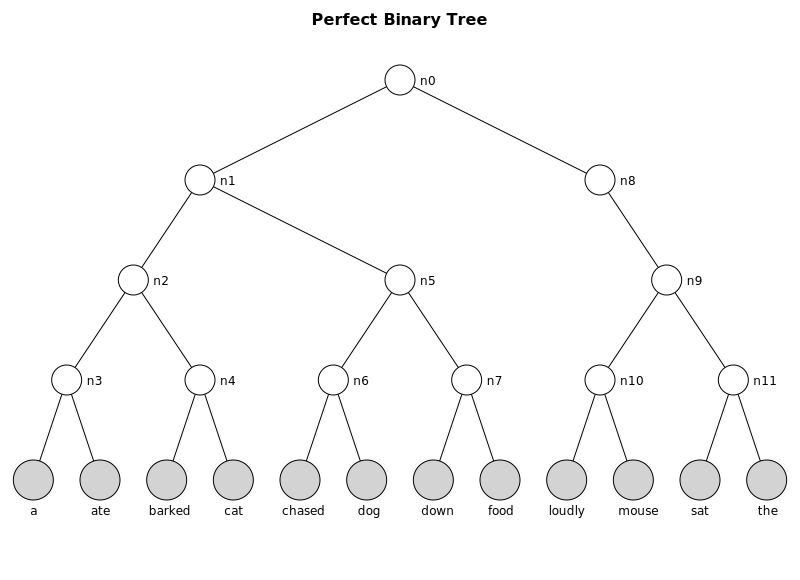

In [11]:

# Build codes for perfect binary tree leaves
def build_perfect_codes(words):
    words = sorted(words)
    n = len(words)
    h = math.ceil(math.log2(n))
    codes = {}
    for i, word in enumerate(words):
        code = format(i, f"0{h}b")   # fixed-length binary code
        codes[word] = code
    return codes, h


def build_perfect_tree(codes):
    root = {"name": "n0"}  # root named n0
    counter = [1]  # mutable counter for naming internal nodes
    
    def insert_code(node, code, word):
        current = node
        for i, bit in enumerate(code):
            is_last_bit = i == len(code) - 1
            
            if bit == "0":
                if "left" not in current:
                    # Only increment counter for internal nodes (not the last bit)
                    if not is_last_bit:
                        current["left"] = {"name": f"n{counter[0]}"}
                        counter[0] += 1
                    else:
                        current["left"] = {"name": word}
                current = current["left"]
            else:
                if "right" not in current:
                    # Only increment counter for internal nodes (not the last bit)
                    if not is_last_bit:
                        current["right"] = {"name": f"n{counter[0]}"}
                        counter[0] += 1
                    else:
                        current["right"] = {"name": word}
                current = current["right"]
        
        if not code:  # Handle empty code case
            node["name"] = word
    
    for word, code in codes.items():
        insert_code(root, code, word)
    return root

codes, height = build_perfect_codes(words)
perfect_tree = build_perfect_tree(codes)

print_tree_analysis(perfect_tree, "Perfect Tree")

perfect_tree_svg = visualize_tree_svg(perfect_tree,title='Perfect Binary Tree')
display(SVG(perfect_tree_svg))      

### Balanced Binary Tree


Balanced binary tree with internal nodes:

Balanced Tree Analysis:
----------------------------------------
Paths to words:
  a          : 000      (depth:  3, freq:  1,   8.3%)
  ate        : 0010     (depth:  4, freq:  1,   8.3%)
  barked     : 0011     (depth:  4, freq:  1,   8.3%)
  cat        : 010      (depth:  3, freq:  1,   8.3%)
  chased     : 0110     (depth:  4, freq:  1,   8.3%)
  dog        : 0111     (depth:  4, freq:  1,   8.3%)
  down       : 100      (depth:  3, freq:  1,   8.3%)
  food       : 1010     (depth:  4, freq:  1,   8.3%)
  loudly     : 1011     (depth:  4, freq:  1,   8.3%)
  mouse      : 110      (depth:  3, freq:  1,   8.3%)
  sat        : 1110     (depth:  4, freq:  1,   8.3%)
  the        : 1111     (depth:  4, freq:  1,   8.3%)

Depth statistics:
  Min depth         : 3
  Max depth         : 4
  Average depth     : 3.67
  Weighted average  : 3.67
  Total frequency   : 12


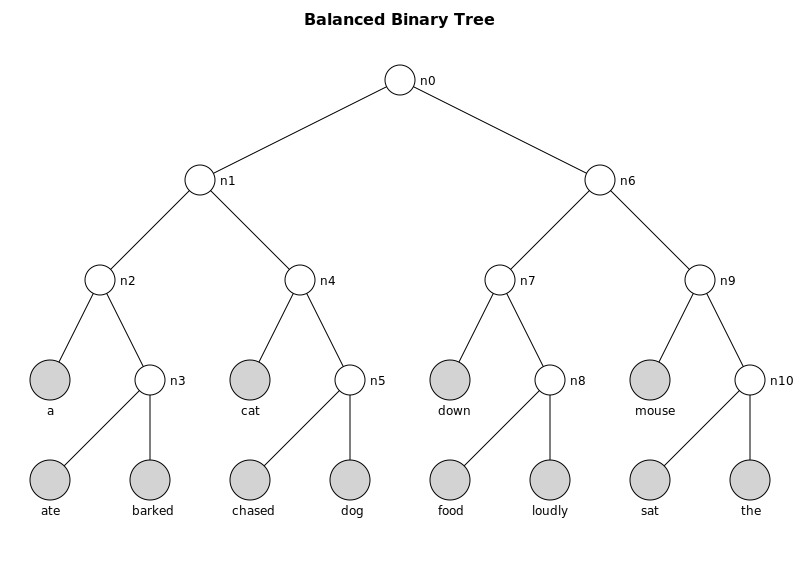

In [12]:
def build_strict_balanced(words):
    counter = [0]  # Mutable counter for naming internal nodes
    
    def build_recursive(words):
        if not words:
            return None
        if len(words) == 1:
            return {"name": words[0]}  # Leaf node - no counter increment
            
        # Internal node - increment counter before creating node
        node_name = f"n{counter[0]}"
        counter[0] += 1
        
        mid = len(words)//2
        node = {
            "name": node_name,
            "left": build_recursive(words[:mid]),
            "right": build_recursive(words[mid:])
        }
        return node
    
    return build_recursive(words)

print("\nBalanced binary tree with internal nodes:")
balanced_tree = build_strict_balanced(words)

print_tree_analysis(balanced_tree, "Balanced Tree")
balanced_tree_svg = visualize_tree_svg(balanced_tree,title='Balanced Binary Tree')
display(SVG(balanced_tree_svg))

### Word Frequency based tree


Huffman Tree Analysis:

Huffman Tree Analysis:
----------------------------------------
Paths to words:
  a          : 1111     (depth:  4, freq:  3,  10.0%)
  ate        : 1011     (depth:  4, freq:  2,   6.7%)
  barked     : 11101    (depth:  5, freq:  1,   3.3%)
  cat        : 011      (depth:  3, freq:  4,  13.3%)
  chased     : 1101     (depth:  4, freq:  2,   6.7%)
  dog        : 100      (depth:  3, freq:  4,  13.3%)
  down       : 1010     (depth:  4, freq:  2,   6.7%)
  food       : 1100     (depth:  4, freq:  2,   6.7%)
  loudly     : 0100     (depth:  4, freq:  1,   3.3%)
  mouse      : 11100    (depth:  5, freq:  1,   3.3%)
  sat        : 0101     (depth:  4, freq:  2,   6.7%)
  the        : 00       (depth:  2, freq:  6,  20.0%)

Depth statistics:
  Min depth         : 2
  Max depth         : 5
  Average depth     : 3.83
  Weighted average  : 3.40
  Total frequency   : 30


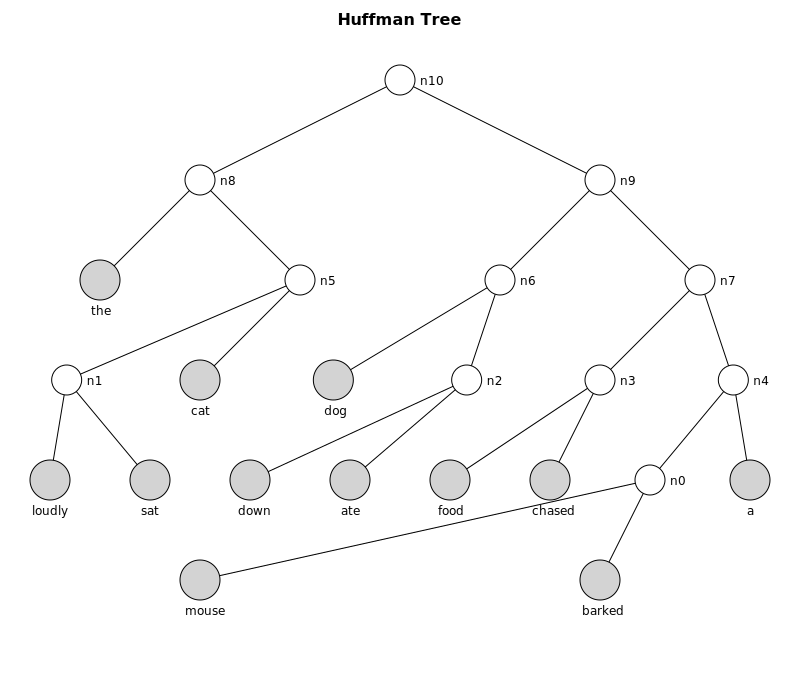

In [13]:
def build_huffman_tree(corpus):
    # Count frequency of each word from corpus sentences
    freq = {}
    for sentence in corpus:
        words_in_sentence = sentence.split()
        for word in words_in_sentence:
            freq[word] = freq.get(word, 0) + 1
    
    # Convert frequencies to list of nodes
    nodes = [{"name": word, "freq": f} for word, f in freq.items()]
    counter = [0]  # For naming internal nodes
    
    # Build tree by combining lowest frequency nodes
    while len(nodes) > 1:
        # Sort by frequency and find two minimum nodes
        nodes.sort(key=lambda x: x["freq"])
        node1 = nodes.pop(0)  # Remove and get lowest freq
        node2 = nodes.pop(0)  # Remove and get second lowest
        
        # Create internal node
        internal = {
            "name": f"n{counter[0]}", 
            "freq": node1["freq"] + node2["freq"],
            "left": node1,
            "right": node2
        }
        counter[0] += 1
        
        # Add back to list
        nodes.append(internal)
    
    return nodes[0] if nodes else None

# Build and analyze Huffman tree
huffman_tree = build_huffman_tree(corpus)

# Print analysis
print("\nHuffman Tree Analysis:")
print_tree_analysis(huffman_tree, "Huffman Tree")


huffman_svg = visualize_tree_svg(huffman_tree,title='Huffman Tree')
display(SVG(huffman_svg))